In [18]:
!pip install flwr
!pip install flwr[simulation]
!pip install tensorflow
!pip install tensorflow_datasets
!pip install matplotlib

  Using cached protobuf-4.25.2-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.2 which is incompatible.
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.2
    Uninstalling protobuf-4.25.2:
      Successfully uninstalled protobuf-4.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import pandas as pd

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from flwr.common import Metrics
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786


# Data Processing

In [20]:
def getCifarData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'cifar10',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [21]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255

In [22]:
trainset,testset, info = getCifarData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


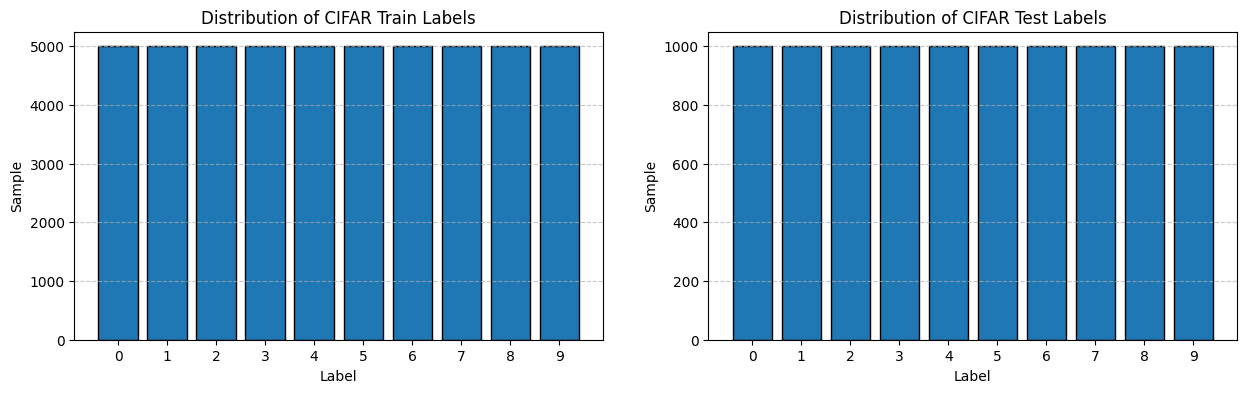

In [23]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of CIFAR Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of CIFAR Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [24]:
def split_intoPartition(data, num_partitions):
    # Calculate the size of each partition
    partition_size = len(data) // num_partitions
    # Split the dataset into partitions
    partitions = [data[i * partition_size:(i + 1) * partition_size] for i in range(num_partitions)]
    return partitions

In [25]:
NumOfPartition = 8
train_image_part = split_intoPartition(Train_images_n,NumOfPartition)
train_label_part = split_intoPartition(Train_label,NumOfPartition)

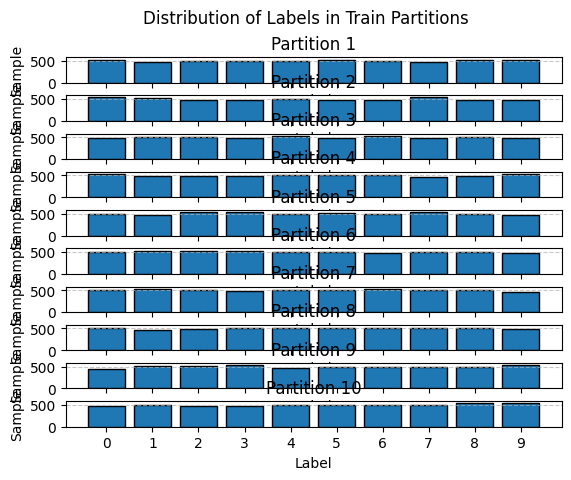

In [26]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

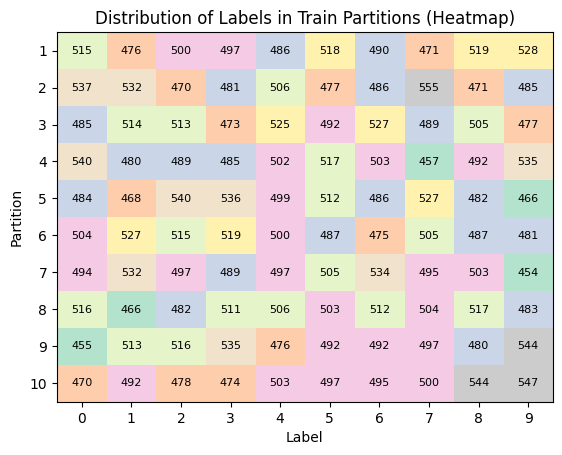

In [27]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [28]:
def simpleRNNModel():
    model = keras.Sequential()
    model.add(keras.layers.Reshape((32, 32 * 3), input_shape=(32, 32, 3)))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [29]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model

    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set,
                                 y=self.train_label_set,
                                 verbose=2,
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [30]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 13,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]

    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [31]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [32]:
globalmodel = simpleRNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [33]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
    )

INFO flwr 2024-02-07 18:52:05,264 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-07 18:52:13,152	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-07 18:52:16,474 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7893314766.0, 'object_store_memory': 3946657382.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7893314766.0, 'object_store_memory': 3946657382.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-07 18:52:16,484 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-07 1

(DefaultActor pid=13407) round :1
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) round :1
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
(DefaultActor pid=13406) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=13406)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 2.0687 - accuracy: 0.2268 - val_loss: 1.9134 - val_accuracy: 0.3038 - 21s/epoch - 135ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 2.0958 - accuracy: 0.2302 - val_loss: 1.9955 - val_accuracy: 0.2730 - 25s/epoch - 159ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.8895 - accuracy: 0.3212 - val_loss: 1.8424 - val_accuracy: 0.3299 - 20s/epoch - 127ms/step
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.8923 - accuracy: 0.2906 - val_loss: 1.8895 - val_accuracy: 0.3079 - 19s/epoch - 120ms/step
(DefaultActor pid=13407) 157/157 - 18s - loss: 1.8107 - accuracy: 0.3460 - val_loss: 1.7568 - val_accuracy: 0.3559 - 18s/epoch - 116ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 23s - loss: 1.7930 - accuracy: 0.3362 - val_loss: 1.8280

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :1
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.4394 - accuracy: 0.4694 - val_loss: 1.6266 - val_accuracy: 0.4186 - 22s/epoch - 141ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :1
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 28s - loss: 2.0761 - accuracy: 0.2322 - val_loss: 1.9774 - val_accuracy: 0.3037 - 28s/epoch - 179ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 27s - loss: 2.0848 - accuracy: 0.2208 - val_loss: 1.9423 - val_accuracy: 0.2967 - 27s/epoch - 173ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.8784 - accuracy: 0.3178 - val_loss: 1.8173 - val_accuracy: 0.3387 - 20s/epoch - 126ms/step
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.9105 - accuracy: 0.2964 - val_loss: 1.8763 - val_accuracy: 0.2998 - 20s/epoch - 129ms/step
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.8068 - accuracy: 0.3380 - val_loss: 1.8537 - val_accuracy: 0.3349 - 21s/epoch - 134ms/step
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.8107 - accura

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.4805 - accuracy: 0.4674 - val_loss: 1.6246 - val_accuracy: 0.4107 - 22s/epoch - 137ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :1
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 2.1160 - accuracy: 0.2150 - val_loss: 1.9432 - val_accuracy: 0.2847 - 26s/epoch - 165ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 2.0775 - accuracy: 0.2360 - val_loss: 1.9642 - val_accuracy: 0.2928 - 26s/epoch - 163ms/step
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.9239 - accuracy: 0.2968 - val_loss: 1.8680 - val_accuracy: 0.3209 - 19s/epoch - 123ms/step
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.8782 - accuracy: 0.3156 - val_loss: 1.8617 - val_accuracy: 0.3321 - 20s/epoch - 128ms/step
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.8475 - accuracy: 0.3280 - val_loss: 1.7736 - val_accuracy: 0.3534 - 23s/epoch - 147ms/step
(DefaultActor pid=1

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.4346 - accuracy: 0.4884 - val_loss: 1.6395 - val_accuracy: 0.4073 - 22s/epoch - 139ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :1
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 2.0966 - accuracy: 0.2280 - val_loss: 1.9499 - val_accuracy: 0.2914 - 27s/epoch - 172ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 2.0925 - accuracy: 0.2230 - val_loss: 1.9518 - val_accuracy: 0.2944 - 26s/epoch - 164ms/step
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.9135 - accuracy: 0.2940 - val_loss: 1.8516 - val_accuracy: 0.3303 - 19s/epoch - 123ms/step
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.8875 - accuracy: 0.3050 - val_loss: 1.8450 - val_accuracy: 0.3271 - 19s/epoch - 121ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.8243 - accuracy: 0.3400 - val_loss: 1.8394 - val_accuracy: 0.3256 - 20s/epoch - 127ms/step
(DefaultActor pid=1

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.4799 - accuracy: 0.4628 - val_loss: 1.6841 - val_accuracy: 0.3975 - 20s/epoch - 128ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :1
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 2.0915 - accuracy: 0.2306 - val_loss: 1.9747 - val_accuracy: 0.2744 - 26s/epoch - 167ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 2.1121 - accuracy: 0.2148 - val_loss: 2.0339 - val_accuracy: 0.2573 - 25s/epoch - 157ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.9047 - accuracy: 0.3098 - val_loss: 1.8495 - val_accuracy: 0.3277 - 20s/epoch - 127ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.9087 - accuracy: 0.2976 - val_loss: 1.8458 - val_accuracy: 0.3248 - 21s/epoch - 132ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.8446 - accuracy: 0.3316 - val_loss: 1.8211 - val_accuracy: 0.3389 - 20s/epoch - 127ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 19s - loss: 1

DEBUG flwr 2024-02-07 19:10:08,934 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-07 19:10:08,958 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) 157/157 - 15s - loss: 1.4806 - accuracy: 0.4678 - val_loss: 1.6307 - val_accuracy: 0.4189 - 15s/epoch - 93ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 127s - loss: 1.6411 - accuracy: 0.4121 - 127s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 128s - loss: 1.6411 - accuracy: 0.4121 - 128s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 127s - loss: 1.6411 - accuracy: 0.4121 - 127s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 133s - loss: 1.6411 - accuracy: 0.4121 - 133s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 141s - loss: 1.6411 - accuracy: 0.4121 - 141s/epoch - 14ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


DEBUG flwr 2024-02-07 19:21:14,384 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-07 19:21:14,388 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) round :2
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 1.6462 - accuracy: 0.3960 - val_loss: 1.5915 - val_accuracy: 0.4243 - 28s/epoch - 177ms/step
(DefaultActor pid=13406) 10000/10000 - 139s - loss: 1.6411 - accuracy: 0.4121 - 139s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13407) round :2
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.5711 - accuracy: 0.4284 - val_loss: 1.5916 - val_accuracy: 0.4116 - 20s/epoch - 130ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 23s - loss: 1.5160 - accuracy: 0.4476 - val_loss: 1.5872 - val_accuracy: 0.4243 - 23s/epoch - 147ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/15

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 26s - loss: 1.6189 - accuracy: 0.4116 - val_loss: 1.6114 - val_accuracy: 0.4128 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) round :2
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.5521 - accuracy: 0.4366 - val_loss: 1.6217 - val_accuracy: 0.4138 - 21s/epoch - 133ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.4967 - accuracy: 0.4604 - val_loss: 1.5831 - val_accuracy: 0.4289 - 20s/epoch - 126ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.4552 - accuracy: 0.4634 - val_loss: 1.6

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) round :2
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.1694 - accuracy: 0.5750 - val_loss: 1.6050 - val_accuracy: 0.4406 - 23s/epoch - 143ms/step
(DefaultActor pid=13407) round :2
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.6454 - accuracy: 0.4076 - val_loss: 1.5820 - val_accuracy: 0.4213 - 25s/epoch - 157ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 24s - loss: 1.6431 - accuracy: 0.4072 - val_loss: 1.5961 - val_accuracy: 0.4205 - 24s/epoch - 153ms/step
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.5823 - accuracy: 0.4296 - val_loss: 1.6167 - val_accuracy: 0.4186 - 19s/epoch - 122ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.5804 - accuracy: 0.4256 - val_loss: 1.6114 - val_accuracy: 0.4191 - 21s/epoch - 133ms/step
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.5317 - accuracy: 0.4414 - val_loss: 1.6000 - val_accuracy: 0.4264 - 21s/epoch - 136ms/step
(DefaultActor pid=13406) Epoch 4/10
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13407) 157/157 - 20s - loss: 1

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 157/157 - 19s - loss: 1.1804 - accuracy: 0.5706 - val_loss: 1.6316 - val_accuracy: 0.4299 - 19s/epoch - 122ms/step
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) round :2
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 1.6484 - accuracy: 0.4076 - val_loss: 1.6316 - val_accuracy: 0.4110 - 26s/epoch - 167ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.5717 - accuracy: 0.4334 - val_loss: 1.5667 - val_accuracy: 0.4367 - 19s/epoch - 123ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.5725 - accuracy: 0.4326 - val_loss: 1.5784 - val_accuracy: 0.4263 - 21s/epoch - 131ms/step
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.5198 - accuracy

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.1870 - accuracy: 0.5756 - val_loss: 1.5400 - val_accuracy: 0.4565 - 19s/epoch - 121ms/step
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 26s - loss: 1.6492 - accuracy: 0.4020 - val_loss: 1.6049 - val_accuracy: 0.4179 - 26s/epoch - 167ms/step
(DefaultActor pid=13407) round :2
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.5795 - accuracy: 0.4258 - val_loss: 1.5966 - val_accuracy: 0.4203 - 19s/epoch - 124ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.5770 - accuracy: 0.4342 - val_loss: 1.5788 - val_accuracy: 0.4275 - 21s/epoch - 132ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 22s - l

DEBUG flwr 2024-02-07 19:38:50,663 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-07 19:38:50,688 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 138s - loss: 1.4665 - accuracy: 0.4813 - 138s/epoch - 14ms/step
(DefaultActor pid=13407) Global Validate Done!!!
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 17s - loss: 1.2060 - accuracy: 0.5668 - val_loss: 1.5956 - val_accuracy: 0.4336 - 17s/epoch - 110ms/step


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) 10000/10000 - 132s - loss: 1.4665 - accuracy: 0.4813 - 132s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 127s - loss: 1.4665 - accuracy: 0.4813 - 127s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 126s - loss: 1.4665 - accuracy: 0.4813 - 126s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 126s - loss: 1.4665 - accuracy: 0.4813 - 126s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


DEBUG flwr 2024-02-07 19:49:51,569 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-07 19:49:51,577 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) round :3
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 1.4984 - accuracy: 0.4588 - val_loss: 1.5295 - val_accuracy: 0.4502 - 26s/epoch - 166ms/step
(DefaultActor pid=13406) 10000/10000 - 127s - loss: 1.4665 - accuracy: 0.4813 - 127s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13407) round :3
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.4031 - accuracy: 0.4938 - val_loss: 1.4684 - val_accuracy: 0.4736 - 19s/epoch - 122ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.3463 - accuracy: 0.5134 - val_loss: 1.4818 - val_accuracy: 0.4643 - 21s/epoch - 136ms/step [repeated 2x acro

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :3
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 26s - loss: 1.4814 - accuracy: 0.4728 - val_loss: 1.5516 - val_accuracy: 0.4498 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :3
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.3885 - accuracy: 0.5026 - val_loss: 1.4788 - val_accuracy: 0.4663 - 19s/epoch - 124ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.3352 - accuracy: 0.5164 - val_loss: 1.4686 - val_accuracy: 0.4661 - 23s/epoch - 148ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x acr

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :3
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 26s - loss: 1.4989 - accuracy: 0.4696 - val_loss: 1.5032 - val_accuracy: 0.4526 - 26s/epoch - 169ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :3
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.3978 - accuracy: 0.4976 - val_loss: 1.4954 - val_accuracy: 0.4621 - 19s/epoch - 123ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.3476 - accuracy: 0.5126 - val_loss: 1.4798 - val_accuracy: 0.4661 - 22s/epoch - 139ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x acr

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 26s - loss: 1.4622 - accuracy: 0.4734 - val_loss: 1.4684 - val_accuracy: 0.4740 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :3
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.3755 - accuracy: 0.4988 - val_loss: 1.4800 - val_accuracy: 0.4705 - 19s/epoch - 122ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.3058 - accuracy: 0.5226 - val_loss: 1.4843 - val_accuracy: 0.4669 - 21s/epoch - 136ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.2606 - accuracy: 0.5484 - val_loss: 1.5113 - v

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 26s - loss: 1.4721 - accuracy: 0.4720 - val_loss: 1.5024 - val_accuracy: 0.4571 - 26s/epoch - 166ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :3
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.3844 - accuracy: 0.4986 - val_loss: 1.4848 - val_accuracy: 0.4601 - 19s/epoch - 122ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.3194 - accuracy: 0.5214 - val_loss: 1.4859 - val_accuracy: 0.4629 - 22s/epoch - 139ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.2881 - accuracy: 0.5376 - val_loss: 1.5105 - v

DEBUG flwr 2024-02-07 20:07:22,749 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-07 20:07:22,771 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]
(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 112s - loss: 1.4651 - accuracy: 0.5038 - 112s/epoch - 11ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 20s - loss: 0.9313 - accuracy: 0.6692 - val_loss: 1.5808 - val_accuracy: 0.4678 - 20s/epoch - 126ms/step


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 126s - loss: 1.4651 - accuracy: 0.5038 - 126s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 127s - loss: 1.4651 - accuracy: 0.5038 - 127s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 125s - loss: 1.4651 - accuracy: 0.5038 - 125s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 130s - loss: 1.4651 - accuracy: 0.5038 - 130s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 144s - loss: 1.4651 - accuracy: 0.5038 - 144s/epoch - 14ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 169s - loss: 1.4651 - accuracy: 0.5038 - 169s/epoch - 17ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 159s - loss: 1.4651 - accuracy: 0.5038 - 159s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 134s - loss: 1.4651 - accuracy: 0.5038 - 134s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


DEBUG flwr 2024-02-07 20:19:05,979 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-07 20:19:05,982 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13407) 10000/10000 - 100s - loss: 1.4651 - accuracy: 0.5038 - 100s/epoch - 10ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :4
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 24s - loss: 1.4014 - accuracy: 0.5012 - val_loss: 1.4694 - val_accuracy: 0.4807 - 24s/epoch - 154ms/step
(DefaultActor pid=13407) round :4
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.2711 - accuracy: 0.5400 - val_loss: 1.4317 - val_accuracy: 0.4913 - 22s/epoch - 138ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1976 - accuracy: 0.5762 - val_loss: 1.4581 - val_accuracy: 0.4803 - 20s/epoch - 125ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.1311 - accuracy: 0.5974 - 

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.3854 - accuracy: 0.5048 - val_loss: 1.4633 - val_accuracy: 0.4717 - 25s/epoch - 158ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) round :4
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.2576 - accuracy: 0.5478 - val_loss: 1.4505 - val_accuracy: 0.4819 - 21s/epoch - 132ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1699 - accuracy: 0.5772 - val_loss: 1.4464 - val_accuracy: 0.4874 - 20s/epoch - 127ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1186 - accuracy: 0.5928 - val_loss: 1.4919 - v

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 28s - loss: 1.4108 - accuracy: 0.5008 - val_loss: 1.4251 - val_accuracy: 0.4860 - 28s/epoch - 180ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) round :4
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.2936 - accuracy: 0.5362 - val_loss: 1.4288 - val_accuracy: 0.4901 - 20s/epoch - 126ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.2011 - accuracy: 0.5706 - val_loss: 1.4553 - val_accuracy: 0.4813 - 22s/epoch - 139ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1353 - accuracy: 0.5988 - val_loss: 1.4717 - v

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) round :4
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 30s - loss: 1.4167 - accuracy: 0.4990 - val_loss: 1.4498 - val_accuracy: 0.4759 - 30s/epoch - 193ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) round :4
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.2917 - accuracy: 0.5346 - val_loss: 1.4657 - val_accuracy: 0.4794 - 21s/epoch - 133ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.2195 - accuracy: 0.5546 - val_loss: 1.4456 - val_accuracy: 0.4798 - 20s/epoch - 129ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x acr

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 28s - loss: 1.4070 - accuracy: 0.4920 - val_loss: 1.4300 - val_accuracy: 0.4815 - 28s/epoch - 178ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) round :4
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.2704 - accuracy: 0.5414 - val_loss: 1.4445 - val_accuracy: 0.4854 - 21s/epoch - 134ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.2124 - accuracy: 0.5602 - val_loss: 1.4460 - val_accuracy: 0.4900 - 21s/epoch - 132ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1319 - accuracy: 0.5894 - val_loss: 1.5

DEBUG flwr 2024-02-07 20:37:09,711 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-07 20:37:09,752 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 129s - loss: 1.4901 - accuracy: 0.5201 - 129s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 19s - loss: 0.7834 - accuracy: 0.7218 - val_loss: 1.6067 - val_accuracy: 0.4800 - 19s/epoch - 121ms/step


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 132s - loss: 1.4901 - accuracy: 0.5201 - 132s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 129s - loss: 1.4901 - accuracy: 0.5201 - 129s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 130s - loss: 1.4901 - accuracy: 0.5201 - 130s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 130s - loss: 1.4901 - accuracy: 0.5201 - 130s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


DEBUG flwr 2024-02-07 20:48:11,607 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-07 20:48:11,610 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) round :5
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) 10000/10000 - 128s - loss: 1.4901 - accuracy: 0.5201 - 128s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 24s - loss: 1.3255 - accuracy: 0.5246 - val_loss: 1.4368 - val_accuracy: 0.4950 - 24s/epoch - 152ms/step
(DefaultActor pid=13407) round :5
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.1663 - accuracy: 0.5770 - val_loss: 1.4241 - val_accuracy: 0.5010 - 22s/epoch - 141ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.0882 - accuracy: 0.6074 - val_loss: 1.4602 - val_accuracy: 0.4984 - 19s/epoch - 123ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.0205 - accuracy: 0.6294 - val_loss: 1.4741 - val_accuracy: 0.4896 - 21s/epoch - 136ms/step [repeated 2x across cluster]
(DefaultActor 

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 0.6633 - accuracy: 0.7772 - val_loss: 1.6871 - val_accuracy: 0.4828 - 20s/epoch - 126ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :5
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) 157/157 - 25s - loss: 1.3618 - accuracy: 0.5208 - val_loss: 1.4696 - val_accuracy: 0.4825 - 25s/epoch - 162ms/step
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 28s - loss: 1.3653 - accuracy: 0.5150 - val_loss: 1.4134 - val_accuracy: 0.4968 - 28s/epoch - 178ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.2103 - accuracy: 0.5650 - val_loss: 1.4448 - val_accuracy: 0.4940 - 21s/epoch - 132ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.1935 - accuracy: 0.5720 - val_loss: 1.4588 - val_ac

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.6860 - accuracy: 0.7652 - val_loss: 1.6931 - val_accuracy: 0.4701 - 22s/epoch - 139ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :5
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 1.3724 - accuracy: 0.5132 - val_loss: 1.4055 - val_accuracy: 0.4976 - 27s/epoch - 170ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 27s - loss: 1.3535 - accuracy: 0.5228 - val_loss: 1.4214 - val_accuracy: 0.4968 - 27s/epoch - 169ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.1918 - accuracy: 0.5648 - val_loss: 1.4589 - val_accuracy: 0.4855 - 20s/epoch - 130ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 1.1948 - accuracy: 0.5716 - val_loss: 1.4609 - val_accuracy: 0.4906 - 20s/epoch - 124ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.1136 - accuracy: 0.6084 - val_loss: 1.4759 - val_accuracy: 0.4848 - 20s/epoch - 131ms/step
(DefaultActo

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.6419 - accuracy: 0.7830 - val_loss: 1.6982 - val_accuracy: 0.4780 - 22s/epoch - 138ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :5
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 1.3619 - accuracy: 0.5162 - val_loss: 1.4183 - val_accuracy: 0.4936 - 27s/epoch - 169ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 1.3346 - accuracy: 0.5296 - val_loss: 1.4468 - val_accuracy: 0.4906 - 26s/epoch - 168ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.2062 - accuracy: 0.5642 - val_loss: 1.4302 - val_accuracy: 0.4941 - 20s/epoch - 130ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 19s - loss: 1.1728 - accuracy: 0.5758 - val_loss: 1.4376 - val_accuracy: 0.4915 - 19s/epoch - 123ms/step
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.1092 - accuracy: 0.6020 - val_loss: 1.4460 - val_accuracy: 0.4978 - 20s/epoch - 128ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 1

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :5
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 23s - loss: 0.6281 - accuracy: 0.7852 - val_loss: 1.7160 - val_accuracy: 0.4690 - 23s/epoch - 145ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :5
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 34s - loss: 1.3451 - accuracy: 0.5186 - val_loss: 1.4373 - val_accuracy: 0.4929 - 34s/epoch - 219ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 35s - loss: 1.3251 - accuracy: 0.5262 - val_loss: 1.4352 - val_accuracy: 0.4944 - 35s/epoch - 222ms/step
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.1789 - accuracy: 0.5742 - val_loss: 1.4694 - val_accuracy: 0.4866 - 22s/epoch - 137ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 23s - loss: 1.1573 - accuracy: 0.5834 - val_loss: 1.4322 - val_accuracy: 0.4953 - 23s/epoch - 144ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.0907 - accuracy: 0.6102 - val_loss: 1.5044 - val_accuracy: 0.4792 - 23s/epoch - 149ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.0661 - accuracy: 0.6286 - val_loss:

DEBUG flwr 2024-02-07 21:06:34,248 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-07 21:06:34,272 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) 157/157 - 17s - loss: 0.6311 - accuracy: 0.7852 - val_loss: 1.6850 - val_accuracy: 0.4830 - 17s/epoch - 105ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 146s - loss: 1.5334 - accuracy: 0.5276 - 146s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 144s - loss: 1.5334 - accuracy: 0.5276 - 144s/epoch - 14ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 147s - loss: 1.5334 - accuracy: 0.5276 - 147s/epoch - 15ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 144s - loss: 1.5334 - accuracy: 0.5276 - 144s/epoch - 14ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) 10000/10000 - 149s - loss: 1.5334 - accuracy: 0.5276 - 149s/epoch - 15ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 146s - loss: 1.5334 - accuracy: 0.5276 - 146s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


DEBUG flwr 2024-02-07 21:18:55,188 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-07 21:18:55,198 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) round :6
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) 10000/10000 - 142s - loss: 1.5334 - accuracy: 0.5276 - 142s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 1.2990 - accuracy: 0.5458 - val_loss: 1.4372 - val_accuracy: 0.4973 - 27s/epoch - 175ms/step
(DefaultActor pid=13407) round :6
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 24s - loss: 1.0944 - accuracy: 0.6060 - val_loss: 1.4317 - val_accuracy: 0.5082 - 24s/epoch - 154ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.9869 - accuracy: 0.6458 - val_loss: 1.4872 - val_accuracy: 0.4961 - 22s/epoch - 141ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 23s - loss: 0.9187 - accuracy: 0.6630 - val_loss: 1.5046 - val_accuracy: 0.4883 - 23s/epoch - 149ms/step [repeated 2x across cluster]
(DefaultActor 

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :6
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 24s - loss: 0.5527 - accuracy: 0.8170 - val_loss: 1.7858 - val_accuracy: 0.4844 - 24s/epoch - 155ms/step
(DefaultActor pid=13407) 157/157 - 30s - loss: 1.3055 - accuracy: 0.5374 - val_loss: 1.4228 - val_accuracy: 0.5040 - 30s/epoch - 190ms/step
(DefaultActor pid=13406) round :6
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.0997 - accuracy: 0.6056 - val_loss: 1.4657 - val_accuracy: 0.4934 - 23s/epoch - 146ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.9884 - accuracy: 0.6466 - val_loss: 1.4693 - val_accur

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.5411 - accuracy: 0.8232 - val_loss: 1.7232 - val_accuracy: 0.4873 - 26s/epoch - 164ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :6
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 31s - loss: 1.3069 - accuracy: 0.5448 - val_loss: 1.4112 - val_accuracy: 0.5052 - 31s/epoch - 198ms/step
(DefaultActor pid=13406) 157/157 - 30s - loss: 1.3275 - accuracy: 0.5394 - val_loss: 1.4510 - val_accuracy: 0.5064 - 30s/epoch - 190ms/step
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.1272 - accuracy: 0.5980 - val_loss: 1.4394 - val_accuracy: 0.5003 - 22s/epoch - 140ms/step
(DefaultActor pid=13406) 157/157 - 24s - loss: 1.1404 - accuracy: 0.5928 - val_loss: 1.4804 - val_accuracy:

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 0.5738 - accuracy: 0.8088 - val_loss: 1.7634 - val_accuracy: 0.4708 - 25s/epoch - 158ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :6
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 32s - loss: 1.3331 - accuracy: 0.5346 - val_loss: 1.4410 - val_accuracy: 0.4942 - 32s/epoch - 202ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 30s - loss: 1.2966 - accuracy: 0.5364 - val_loss: 1.4111 - val_accuracy: 0.5066 - 30s/epoch - 190ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.1411 - accuracy: 0.5884 - val_loss: 1.4522 - val_accuracy: 0.4904 - 22s/epoch - 137ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.0837 - accuracy: 0.6096 - val_loss: 1.4714 - val_accuracy: 0.4948 - 25s/epoch - 158ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 25s - loss: 1.0265 - accuracy: 0.6296 - val_loss: 1.5213 - val_accuracy: 0.4813 - 25s/epoch - 158ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 0.9718 - accuracy: 0.6530 - val_loss:

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :6
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 24s - loss: 0.5247 - accuracy: 0.8276 - val_loss: 1.7808 - val_accuracy: 0.4809 - 24s/epoch - 154ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :6
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 31s - loss: 1.3377 - accuracy: 0.5218 - val_loss: 1.4163 - val_accuracy: 0.5021 - 31s/epoch - 195ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 30s - loss: 1.3067 - accuracy: 0.5482 - val_loss: 1.4416 - val_accuracy: 0.4993 - 30s/epoch - 194ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.1261 - accuracy: 0.5938 - val_loss: 1.4353 - val_accuracy: 0.4990 - 23s/epoch - 147ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.1215 - accuracy: 0.5990 - val_loss: 1.4566 - val_accuracy: 0.4995 - 25s/epoch - 158ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.0292 - accuracy: 0.6344 - val_loss: 1.4796 - val_accuracy: 0.4971 - 23s/epoch - 149ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.0137 - accuracy: 0.6406 - val_loss:

DEBUG flwr 2024-02-07 21:39:07,784 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-07 21:39:07,822 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) 157/157 - 17s - loss: 0.5981 - accuracy: 0.7922 - val_loss: 1.7654 - val_accuracy: 0.4795 - 17s/epoch - 105ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 126s - loss: 1.5784 - accuracy: 0.5278 - 126s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 128s - loss: 1.5784 - accuracy: 0.5278 - 128s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 129s - loss: 1.5784 - accuracy: 0.5278 - 129s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 134s - loss: 1.5784 - accuracy: 0.5278 - 134s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]
DEBUG flwr 2024-02-07 21:50:03,697 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-07 21:50:03,700 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13407) 10000/10000 - 129s - loss: 1.5784 - accuracy: 0.5278 - 129s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :7
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 1.2959 - accuracy: 0.5524 - val_loss: 1.4587 - val_accuracy: 0.5070 - 27s/epoch - 169ms/step
(DefaultActor pid=13406) 10000/10000 - 129s - loss: 1.5784 - accuracy: 0.5278 - 129s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) round :7
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.0334 - accuracy: 0.6256 - val_loss: 1.4961 - val_accuracy: 0.4963 - 21s/epoch - 131ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 20s - loss: 0.9262 - accuracy: 0.6738 - val_loss: 1.5341 - val_accuracy: 0.4954 - 20s/epoch - 127ms/step [repeated 2x acro

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 27s - loss: 1.3042 - accuracy: 0.5456 - val_loss: 1.4236 - val_accuracy: 0.5038 - 27s/epoch - 169ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :7
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 1.0730 - accuracy: 0.6206 - val_loss: 1.4657 - val_accuracy: 0.5028 - 21s/epoch - 134ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 19s - loss: 0.9497 - accuracy: 0.6532 - val_loss: 1.5083 - val_accuracy: 0.5005 - 19s/epoch - 123ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.8570 - accuracy: 0.6960 - val_loss: 1.5536 - v

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 26s - loss: 1.3054 - accuracy: 0.5386 - val_loss: 1.4561 - val_accuracy: 0.5088 - 26s/epoch - 168ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :7
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 20s - loss: 1.0654 - accuracy: 0.6128 - val_loss: 1.4440 - val_accuracy: 0.5077 - 20s/epoch - 127ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 20s - loss: 0.9347 - accuracy: 0.6674 - val_loss: 1.5059 - val_accuracy: 0.4959 - 20s/epoch - 129ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 0.8531 - accuracy: 0.6952 - val_loss: 1.5332 - v

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 0.4481 - accuracy: 0.8534 - val_loss: 1.8805 - val_accuracy: 0.4768 - 21s/epoch - 137ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :7
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 25s - loss: 1.2978 - accuracy: 0.5552 - val_loss: 1.4820 - val_accuracy: 0.4923 - 25s/epoch - 161ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 27s - loss: 1.2854 - accuracy: 0.5482 - val_loss: 1.4652 - val_accuracy: 0.5039 - 27s/epoch - 172ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 19s - loss: 1.0558 - accuracy: 0.6294 - val_loss: 1.4498 - val_accuracy: 0.5105 - 19s/epoch - 123ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.0553 - accuracy: 0.6138 - val_loss: 1.4423 - val_accuracy: 0.5096 - 22s/epoch - 142ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 0.9274 - accuracy: 0.6708 - val_loss: 1.5176 - val_accuracy: 0.4948 - 21s/epoch - 132ms/step
(DefaultActo

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :7
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.4812 - accuracy: 0.8428 - val_loss: 1.8157 - val_accuracy: 0.4881 - 22s/epoch - 141ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :7
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 28s - loss: 1.2871 - accuracy: 0.5604 - val_loss: 1.4879 - val_accuracy: 0.4931 - 28s/epoch - 176ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 1.2679 - accuracy: 0.5602 - val_loss: 1.4642 - val_accuracy: 0.5074 - 25s/epoch - 159ms/step
(DefaultActor pid=13407) 157/157 - 22s - loss: 1.0487 - accuracy: 0.6312 - val_loss: 1.4749 - val_accuracy: 0.5125 - 22s/epoch - 140ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 20s - loss: 0.9170 - accuracy: 0.6756 - val_loss: 1.5107 - val_accuracy: 0.5021 - 20s/epoch - 125ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 0.91

DEBUG flwr 2024-02-07 22:07:52,356 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-07 22:07:52,383 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 130s - loss: 1.6383 - accuracy: 0.5323 - 130s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 18s - loss: 0.4440 - accuracy: 0.8624 - val_loss: 1.8660 - val_accuracy: 0.4747 - 18s/epoch - 117ms/step


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 136s - loss: 1.6383 - accuracy: 0.5323 - 136s/epoch - 14ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) 10000/10000 - 140s - loss: 1.6383 - accuracy: 0.5323 - 140s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 137s - loss: 1.6383 - accuracy: 0.5323 - 137s/epoch - 14ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 138s - loss: 1.6383 - accuracy: 0.5323 - 138s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 134s - loss: 1.6383 - accuracy: 0.5323 - 134s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 137s - loss: 1.6383 - accuracy: 0.5323 - 137s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 135s - loss: 1.6383 - accuracy: 0.5323 - 135s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


DEBUG flwr 2024-02-07 22:19:17,863 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-07 22:19:17,868 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :8
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13406) 10000/10000 - 130s - loss: 1.6383 - accuracy: 0.5323 - 130s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) 157/157 - 28s - loss: 1.2619 - accuracy: 0.5744 - val_loss: 1.4784 - val_accuracy: 0.5071 - 28s/epoch - 178ms/step
(DefaultActor pid=13407) round :8
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13406) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 23s - loss: 1.0138 - accuracy: 0.6322 - val_loss: 1.4765 - val_accuracy: 0.5090 - 23s/epoch - 145ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 0.8846 - accuracy: 0.6868 - val_loss: 1.5226 - val_accuracy: 0.5010 - 21s/epoch - 135ms/step [repeated 2x acro

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 33s - loss: 1.2516 - accuracy: 0.5718 - val_loss: 1.4659 - val_accuracy: 0.5104 - 33s/epoch - 209ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :8
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 21s - loss: 0.9979 - accuracy: 0.6494 - val_loss: 1.5033 - val_accuracy: 0.5118 - 21s/epoch - 132ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 24s - loss: 0.8642 - accuracy: 0.6870 - val_loss: 1.5225 - val_accuracy: 0.5132 - 24s/epoch - 150ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 20s - loss: 0.7610 - accuracy: 0.7328 - val_loss: 1.5468 - v

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :8
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.3885 - accuracy: 0.8806 - val_loss: 1.8749 - val_accuracy: 0.4886 - 22s/epoch - 139ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :8
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) 157/157 - 29s - loss: 1.2640 - accuracy: 0.5612 - val_loss: 1.4894 - val_accuracy: 0.5090 - 29s/epoch - 184ms/step
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 31s - loss: 1.2642 - accuracy: 0.5630 - val_loss: 1.4632 - val_accuracy: 0.5050 - 31s/epoch - 199ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 21s - loss: 0.9871 - accuracy: 0.6412 - val_loss: 1.4832 - val_accuracy: 0.5121 - 21s/epoch - 135ms/step
(DefaultActor pid=13407) Epo

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.4120 - accuracy: 0.8686 - val_loss: 1.9084 - val_accuracy: 0.4719 - 22s/epoch - 142ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :8
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 28s - loss: 1.2446 - accuracy: 0.5754 - val_loss: 1.4770 - val_accuracy: 0.5049 - 28s/epoch - 175ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 30s - loss: 1.2443 - accuracy: 0.5744 - val_loss: 1.4687 - val_accuracy: 0.5062 - 30s/epoch - 188ms/step
(DefaultActor pid=13407) 157/157 - 23s - loss: 0.9875 - accuracy: 0.6464 - val_loss: 1.5235 - val_accuracy: 0.5060 - 23s/epoch - 146ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.9936 - accuracy: 0.6388 - val_loss: 1.4956 - val_accuracy: 0.5079 - 22s/epoch - 139ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.8536 - accuracy: 0.6980 - val_loss: 1.6374 - val_accuracy: 0.4931 - 22s/epoch - 139ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 20s - loss: 0.8472 - accuracy: 0.6924 - val_loss:

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :8
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.4013 - accuracy: 0.8686 - val_loss: 1.8730 - val_accuracy: 0.4886 - 26s/epoch - 164ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) round :8
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 30s - loss: 1.2520 - accuracy: 0.5708 - val_loss: 1.4734 - val_accuracy: 0.5087 - 30s/epoch - 193ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 34s - loss: 1.2558 - accuracy: 0.5684 - val_loss: 1.4902 - val_accuracy: 0.5010 - 34s/epoch - 217ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.9905 - accuracy: 0.6446 - val_loss: 1.4824 - val_accuracy: 0.5100 - 26s/epoch - 165ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 22s - loss: 1.0144 - accuracy: 0.6326 - val_loss: 1.5678 - val_accuracy: 0.4924 - 22s/epoch - 141ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 25s - loss: 0.8510 - accuracy: 0.6990 - val_loss: 1.5450 - val_accuracy: 0.5030 - 25s/epoch - 159ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 0.8704 - accuracy: 0.6890 - val_loss:

DEBUG flwr 2024-02-07 22:39:06,120 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-07 22:39:06,163 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) 157/157 - 12s - loss: 0.4050 - accuracy: 0.8706 - val_loss: 1.8869 - val_accuracy: 0.4758 - 12s/epoch - 74ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 152s - loss: 1.6769 - accuracy: 0.5343 - 152s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 152s - loss: 1.6769 - accuracy: 0.5343 - 152s/epoch - 15ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) 10000/10000 - 156s - loss: 1.6769 - accuracy: 0.5343 - 156s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 146s - loss: 1.6769 - accuracy: 0.5343 - 146s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 145s - loss: 1.6769 - accuracy: 0.5343 - 145s/epoch - 14ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 129s - loss: 1.6769 - accuracy: 0.5343 - 129s/epoch - 13ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 130s - loss: 1.6769 - accuracy: 0.5343 - 130s/epoch - 13ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 151s - loss: 1.6769 - accuracy: 0.5343 - 151s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


DEBUG flwr 2024-02-07 22:51:30,018 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-07 22:51:30,027 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13406) round :9
(DefaultActor pid=13406) 10000/10000 - 147s - loss: 1.6769 - accuracy: 0.5343 - 147s/epoch - 15ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) 
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 21s - loss: 1.2357 - accuracy: 0.5808 - val_loss: 1.5531 - val_accuracy: 0.4962 - 21s/epoch - 132ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 14s - loss: 0.9289 - accuracy: 0.6698 - val_loss: 1.6148 - val_accuracy: 0.4927 - 14s/epoch - 91ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 17s - loss: 0.7888 - accuracy: 0.7122 - val_loss: 1.5941 - val_accuracy: 0.4939 - 17s/epoch - 110ms/step
(DefaultActor pid=13406) Epoch 4/10


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :9
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.6774 - accuracy: 0.7626 - val_loss: 1.6689 - val_accuracy: 0.4978 - 26s/epoch - 163ms/step
(DefaultActor pid=13406) Epoch 5/10
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 34s - loss: 1.2638 - accuracy: 0.5766 - val_loss: 1.5068 - val_accuracy: 0.5118 - 34s/epoch - 215ms/step
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.6134 - accuracy: 0.7884 - val_loss: 1.7266 - val_accuracy: 0.4915 - 28s/epoch - 179ms/step
(DefaultActor pid=13406) Epoch 6/10
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 27s - loss: 0.9722 - accuracy: 0.6562 - val_loss: 1.5860 - val_accuracy: 0.4995 - 27s/epoch - 174ms/step
(DefaultActor pid=13406) 157/157 - 27s - loss: 0.5380 - accuracy: 0.8200 - val_loss: 1.7675 - val_accuracy: 0.4850 - 27s/epoch - 174ms/step
(DefaultActo

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :9
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.5013 - accuracy: 0.8360 - val_loss: 1.8113 - val_accuracy: 0.4807 - 26s/epoch - 168ms/step
(DefaultActor pid=13407) Epoch 8/10
(DefaultActor pid=13406) 157/157 - 38s - loss: 1.2441 - accuracy: 0.5720 - val_loss: 1.5038 - val_accuracy: 0.5162 - 38s/epoch - 242ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.9631 - accuracy: 0.6530 - val_loss: 1.5557 - val_accuracy: 0.5005 - 28s/epoch - 180ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 25s - loss: 0.3641 - accuracy: 0.8886 - val_loss: 1.9407 - val_accuracy: 0.4841 - 25s/epoch - 160ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 10/10
(Defa

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.7089 - accuracy: 0.7454 - val_loss: 1.6058 - val_accuracy: 0.5058 - 28s/epoch - 179ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 5/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 36s - loss: 1.2415 - accuracy: 0.5780 - val_loss: 1.5151 - val_accuracy: 0.4980 - 36s/epoch - 231ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.6242 - accuracy: 0.7794 - val_loss: 1.6556 - val_accuracy: 0.4934 - 28s/epoch - 177ms/step
(DefaultActor pid=13406) Epoch 6/10
(DefaultActor pid=13407) 157/157 - 28s - loss: 0.9644 - accuracy: 0.6556 - val_loss: 1.4986 - val_accuracy: 0.5139 - 28s/epoch - 176ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 0.5427 - accuracy: 0.8174 - val_loss: 1.7101 - val_accuracy: 0.4891 - 25s/epoch - 160ms/step
(DefaultActor pid=13406) Epoch 7/10
(DefaultActor pid=13406) 1

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :9
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 25s - loss: 0.4692 - accuracy: 0.8446 - val_loss: 1.8656 - val_accuracy: 0.4839 - 25s/epoch - 162ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 9/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 27s - loss: 0.4043 - accuracy: 0.8730 - val_loss: 1.8729 - val_accuracy: 0.4921 - 27s/epoch - 172ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 10/10 [repeated 2x across cluster]
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.3839 - accuracy: 0.8776 - val_loss: 1.9022 - val_accuracy: 0.4885 - 22s/epoch - 138ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) round :9
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.7729 - accuracy: 0.7248 - val_loss: 1.5903 - val_accuracy: 0.5015 - 26s/epoch - 166ms/step
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.6851 - accuracy: 0.7620 - val_loss: 1.6516 - val_accuracy: 0.5038 - 26s/epoch - 168ms/step
(DefaultActor pid=13406) Epoch 4/10
(DefaultActor pid=13406) Epoch 5/10
(DefaultActor pid=13407) 157/157 - 38s - loss: 1.2398 - accuracy: 0.5834 - val_loss: 1.5258 - val_accuracy: 0.5054 - 38s/epoch - 241ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 29s - loss: 0.5923 - accuracy: 0.7954 - val_loss: 1.6939 - val_accuracy: 0.4991 - 29s/epoch - 187ms/step
(DefaultActor pid=13406) Epoch 6/10
(DefaultActor pid=13407) 157/157 - 29s - loss: 0.9435 - accuracy: 0.6630 - val_loss: 1.5570 - val_accuracy: 0.5096 - 29s/epoch - 188ms/step
(DefaultActo

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :9
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.4203 - accuracy: 0.8676 - val_loss: 1.8815 - val_accuracy: 0.4899 - 26s/epoch - 167ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 9/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.4358 - accuracy: 0.8572 - val_loss: 1.8809 - val_accuracy: 0.4871 - 26s/epoch - 166ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 10/10 [repeated 2x across cluster]
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 27s - loss: 0.3331 - accuracy: 0.9030 - val_loss: 1.9606 - val_accuracy: 0.4846 - 27s/epoch - 172ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) round :9
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.6819 - accuracy: 0.7642 - val_loss: 1.6365 - val_accuracy: 0.5007 - 26s/epoch - 167ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 5/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.5923 - accuracy: 0.7986 - val_loss: 1.6997 - val_accuracy: 0.4984 - 26s/epoch - 168ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 6/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 22s - loss: 0.5295 - accuracy: 0.8198 - val_loss: 1.7508 - val_accuracy: 0.4978 - 22s/epoch - 141ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 7/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.8163 - accuracy: 0.7070 - val_loss: 1.5985 - val_accuracy: 0.5017 - 26s/epoch - 168ms/step
(DefaultActor pid=13407) Epoch 4/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.4856 - accuracy: 0.8414 - val_loss: 1

(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :9
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.4493 - accuracy: 0.8516 - val_loss: 1.8730 - val_accuracy: 0.4821 - 26s/epoch - 167ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 9/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 25s - loss: 0.4244 - accuracy: 0.8614 - val_loss: 1.8756 - val_accuracy: 0.4725 - 25s/epoch - 161ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 10/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 27s - loss: 0.9349 - accuracy: 0.6606 - val_loss: 1.5238 - val_accuracy: 0.4992 - 27s/epoch - 169ms/step
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.3719 - accuracy: 0.8834 - val_loss: 1.9449 - val_accuracy: 0.4678 - 26s/epoch - 165ms/step
(DefaultActor pid=13407) Client Train and validate Done!!!
(DefaultActo

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 25s - loss: 0.6760 - accuracy: 0.7568 - val_loss: 1.6378 - val_accuracy: 0.5020 - 25s/epoch - 157ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) Epoch 5/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 34s - loss: 1.2516 - accuracy: 0.5746 - val_loss: 1.5048 - val_accuracy: 0.5118 - 34s/epoch - 216ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 24s - loss: 0.5921 - accuracy: 0.7922 - val_loss: 1.7018 - val_accuracy: 0.4941 - 24s/epoch - 155ms/step
(DefaultActor pid=13406) Epoch 6/10
(DefaultActor pid=13407) 157/157 - 24s - loss: 0.9530 - accuracy: 0.6594 - val_loss: 1.5358 - val_accuracy: 0.5077 - 24s/epoch - 156ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 26s - loss: 0.5524 - accuracy: 0.8126 - val_loss: 1.7555 - val_accuracy: 0.4918 - 26s/epoch - 166ms/step
(DefaultActor pid=13406) Epoch 7/10
(DefaultActor pid=13406) 1

DEBUG flwr 2024-02-07 23:14:21,560 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures
DEBUG flwr 2024-02-07 23:14:21,602 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 10 clients (out of 10)


(DefaultActor pid=13407) 157/157 - 10s - loss: 0.4100 - accuracy: 0.8690 - val_loss: 1.9154 - val_accuracy: 0.4919 - 10s/epoch - 65ms/step
(DefaultActor pid=13407) Client Train and validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 158s - loss: 1.7451 - accuracy: 0.5339 - 158s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 154s - loss: 1.7451 - accuracy: 0.5339 - 154s/epoch - 15ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) 10000/10000 - 154s - loss: 1.7451 - accuracy: 0.5339 - 154s/epoch - 15ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Global Validate Done!!! [repeated 2x across cluster]


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) 10000/10000 - 155s - loss: 1.7451 - accuracy: 0.5339 - 155s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 154s - loss: 1.7451 - accuracy: 0.5339 - 154s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 153s - loss: 1.7451 - accuracy: 0.5339 - 153s/epoch - 15ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13407) 10000/10000 - 152s - loss: 1.7451 - accuracy: 0.5339 - 152s/epoch - 15ms/step
(DefaultActor pid=13407) Global Validate Done!!!


DEBUG flwr 2024-02-07 23:27:32,263 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2024-02-07 23:27:32,272 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13406) round :10
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 33s - loss: 1.2316 - accuracy: 0.5920 - val_loss: 1.5612 - val_accuracy: 0.5062 - 33s/epoch - 208ms/step
(DefaultActor pid=13406) 10000/10000 - 150s - loss: 1.7451 - accuracy: 0.5339 - 150s/epoch - 15ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13407) round :10
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 23s - loss: 0.9128 - accuracy: 0.6784 - val_loss: 1.6378 - val_accuracy: 0.5038 - 23s/epoch - 148ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 22s - loss: 0.7617 - accuracy: 0.7368 - val_loss: 1.6576 - val_accuracy: 0.4924 - 22s/epoch - 141ms/step [repeated 2x ac

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13406) 157/157 - 27s - loss: 0.2988 - accuracy: 0.9074 - val_loss: 2.0206 - val_accuracy: 0.4919 - 27s/epoch - 169ms/step
(DefaultActor pid=13407) 157/157 - 41s - loss: 1.2472 - accuracy: 0.5768 - val_loss: 1.5076 - val_accuracy: 0.5136 - 41s/epoch - 259ms/step
(DefaultActor pid=13406) round :10
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 24s - loss: 0.9229 - accuracy: 0.6682 - val_loss: 1.5936 - val_accuracy: 0.5056 - 24s/epoch - 156ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.7638 - accuracy: 0.7294 - val_loss: 1.6322 - val_accuracy: 0.5031 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 31s - loss: 1.2464 - accuracy: 0.5802 - val_loss: 1.5343 - val_accuracy: 0.5146 - 31s/epoch - 200ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :10
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.9060 - accuracy: 0.6798 - val_loss: 1.5847 - val_accuracy: 0.5076 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 3/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.7553 - accuracy: 0.7300 - val_loss: 1.6372 - val_accuracy: 0.5099 - 26s/epoch - 165ms/step [repeated 2x across cluster]
(DefaultActor pid=13407) Epoch 4/10 [repeated 2x across cluster]
(DefaultActor pid=13407) 157/157 - 25s - loss: 0.6378 - accuracy: 0.7786 - val_loss: 1.6545 - 

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :10
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) Client Train and validate Done!!!
(DefaultActor pid=13407) 157/157 - 32s - loss: 1.1997 - accuracy: 0.5962 - val_loss: 1.5547 - val_accuracy: 0.5079 - 32s/epoch - 201ms/step [repeated 2x across cluster]
(DefaultActor pid=13406) round :10
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13407) Epoch 2/10 [repeated 2x across cluster]
(DefaultActor pid=13406) 157/157 - 34s - loss: 1.2239 - accuracy: 0.5872 - val_loss: 1.5096 - val_accuracy: 0.5147 - 34s/epoch - 215ms/step
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.8886 - accuracy: 0.6848 - val_loss: 1.5897 - val_accuracy: 0.5061 - 26s/epoch - 165ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13407) 157/157 - 24s - loss: 0.7085 - accuracy: 0.7482 - val_loss: 1.6906 - val_acc

(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables.  [repeated 2x across cluster]


(DefaultActor pid=13407) round :10
(DefaultActor pid=13407) Train :5000
(DefaultActor pid=13407) Test :10000
(DefaultActor pid=13407) Epoch 1/10
(DefaultActor pid=13406) 157/157 - 28s - loss: 0.3230 - accuracy: 0.8982 - val_loss: 2.0097 - val_accuracy: 0.4866 - 28s/epoch - 180ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) round :10
(DefaultActor pid=13406) Train :5000
(DefaultActor pid=13406) Test :10000
(DefaultActor pid=13406) Epoch 1/10
(DefaultActor pid=13407) 157/157 - 37s - loss: 1.2021 - accuracy: 0.5990 - val_loss: 1.5353 - val_accuracy: 0.5102 - 37s/epoch - 234ms/step
(DefaultActor pid=13407) Epoch 2/10
(DefaultActor pid=13406) Epoch 2/10
(DefaultActor pid=13406) 157/157 - 33s - loss: 1.2142 - accuracy: 0.5872 - val_loss: 1.5500 - val_accuracy: 0.5033 - 33s/epoch - 209ms/step
(DefaultActor pid=13407) 157/157 - 26s - loss: 0.9094 - accuracy: 0.6794 - val_loss: 1.6156 - val_accuracy: 0.5064 - 26s/epoch - 163ms/step
(DefaultActor pid=13407) Epoch 3/10
(DefaultActor pid=13406) Epoch 3/10
(DefaultActor pid=13406) 157/157 - 27s - loss: 0.9009 - accuracy: 0.6758 - val_loss: 1.6277 - val_accuracy: 0.4947 - 27s/epoch - 173ms/step
(DefaultActor pid=13407) 157/157 - 23s - loss: 0.7476 - accuracy: 0.7342 - val_loss: 1.6398 - val_accuracy: 0.5025 - 23s/epoch - 148ms/step
(DefaultAct

DEBUG flwr 2024-02-07 23:49:29,038 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures
DEBUG flwr 2024-02-07 23:49:29,068 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 10 clients (out of 10)
(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 111s - loss: 1.7968 - accuracy: 0.5321 - 111s/epoch - 11ms/step
(DefaultActor pid=13406) Global Validate Done!!!
(DefaultActor pid=13406) 157/157 - 21s - loss: 0.3122 - accuracy: 0.9048 - val_loss: 2.0206 - val_accuracy: 0.4825 - 21s/epoch - 136ms/step
(DefaultActor pid=13406) Client Train and validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 160s - loss: 1.7968 - accuracy: 0.5321 - 160s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 163s - loss: 1.7968 - accuracy: 0.5321 - 163s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 158s - loss: 1.7968 - accuracy: 0.5321 - 158s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 162s - loss: 1.7968 - accuracy: 0.5321 - 162s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 158s - loss: 1.7968 - accuracy: 0.5321 - 158s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 160s - loss: 1.7968 - accuracy: 0.5321 - 160s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


(DefaultActor pid=13406) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13407) 10000/10000 - 160s - loss: 1.7968 - accuracy: 0.5321 - 160s/epoch - 16ms/step
(DefaultActor pid=13407) Global Validate Done!!!


(DefaultActor pid=13407) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=13406) 10000/10000 - 164s - loss: 1.7968 - accuracy: 0.5321 - 164s/epoch - 16ms/step
(DefaultActor pid=13406) Global Validate Done!!!


DEBUG flwr 2024-02-08 00:03:03,446 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 10 results and 0 failures
INFO flwr 2024-02-08 00:03:03,451 | server.py:153 | FL finished in 18626.960904621
INFO:flwr:FL finished in 18626.960904621
INFO flwr 2024-02-08 00:03:03,453 | app.py:226 | app_fit: losses_distributed [(1, 1.6411255598068237), (2, 1.4664673805236816), (3, 1.4651155471801758), (4, 1.4900765419006348), (5, 1.5334341526031494), (6, 1.578360915184021), (7, 1.638283371925354), (8, 1.6768558025360107), (9, 1.7451285123825073), (10, 1.796769142150879)]
INFO:flwr:app_fit: losses_distributed [(1, 1.6411255598068237), (2, 1.4664673805236816), (3, 1.4651155471801758), (4, 1.4900765419006348), (5, 1.5334341526031494), (6, 1.578360915184021), (7, 1.638283371925354), (8, 1.6768558025360107), (9, 1.7451285123825073), (10, 1.796769142150879)]
INFO flwr 2024-02-08 00:03:03,455 | app.py:227 | app_fit: metrics_distributed_fit {'example':

(DefaultActor pid=13407) 10000/10000 - 99s - loss: 1.7968 - accuracy: 0.5321 - 99s/epoch - 10ms/step
(DefaultActor pid=13407) Global Validate Done!!!


In [34]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

In [35]:
print(f"Local evalution :{Val_acc_result}")
print(f"global evalution :{Test_acc_result}")


Local evalution :[41.342, 44.5, 46.025, 47.012, 47.489, 48.196, 48.129, 48.362, 48.623, 48.708]
global evalution :[41.21, 48.13, 50.38, 52.01, 52.76, 52.78, 53.23, 53.43, 53.39, 53.21]


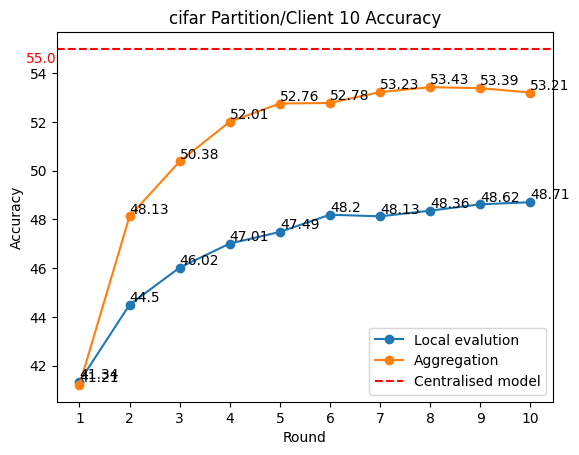

In [44]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"cifar Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value= 55.00
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')
plt.gca().text(0, average_value/60, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()
plt.show()